# Branch and Bound, Relaxation for KSP

## The Knapsack Problem
Given a set of item $I$ , each item $i \in I$ characterized by:
* its weight $w_i$
* its value $v_i$  

and

* a capaciy $K$ for a knapsack

find the subset of items in $I$
* that has maximum value 
* does not exceed the capacity of the knapsack

## Branch and Bound
If you imagine the problem as a decision diagram, the problem has $2^n$ possible solutions. For example, a 3-item binary knapsack problem can be solved using this decision tree:

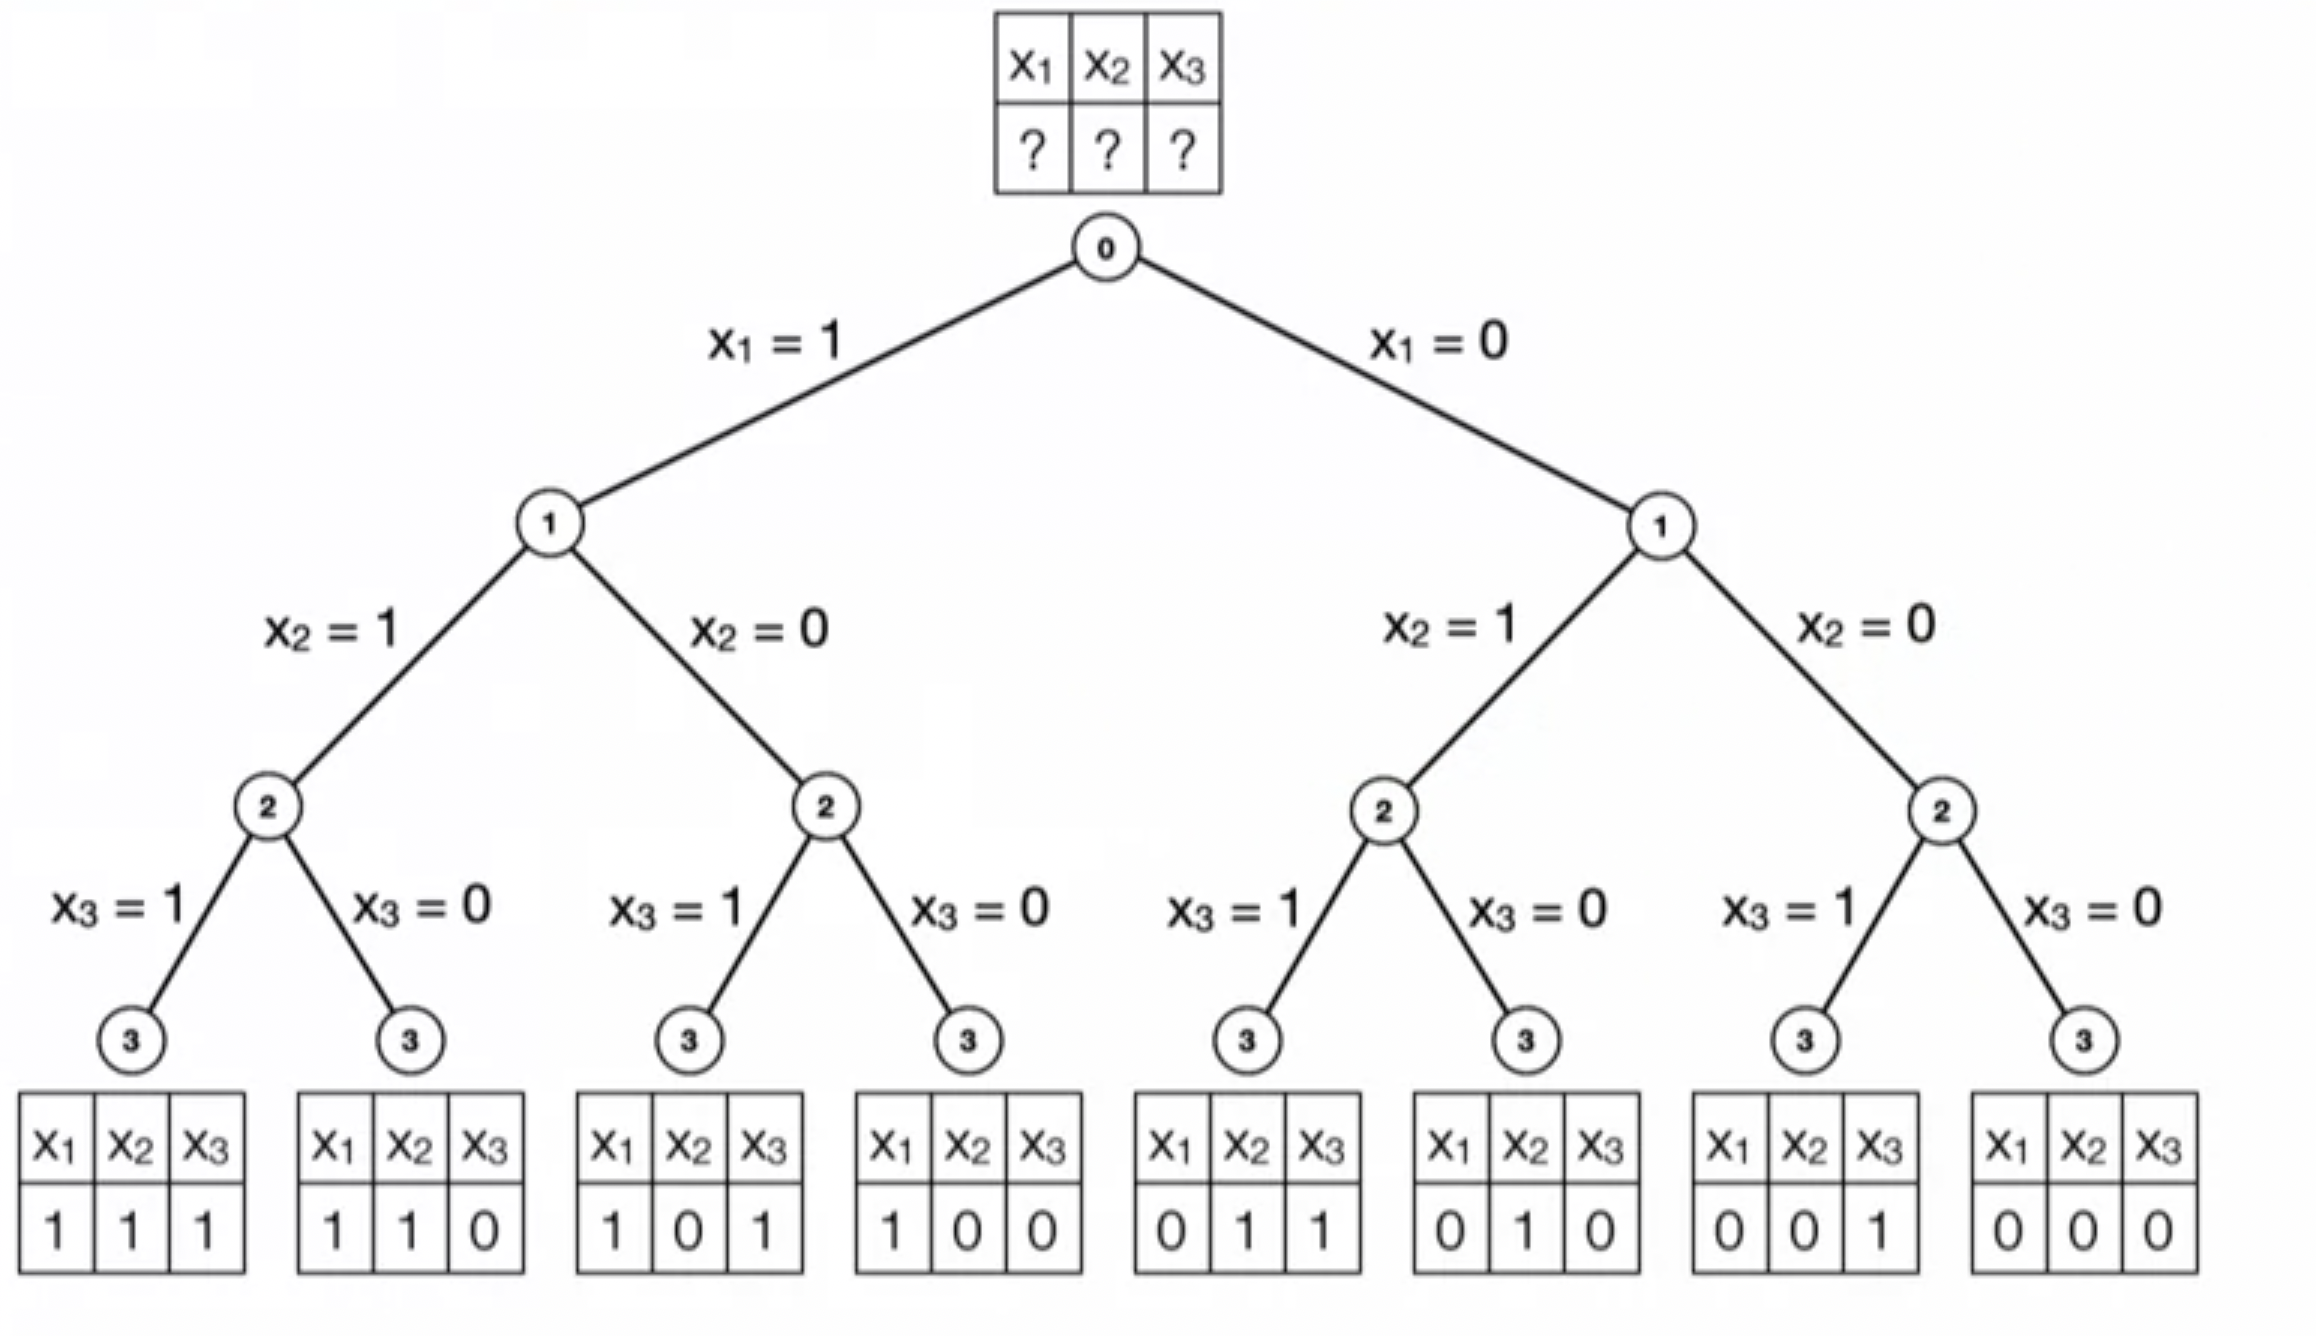

In the dynamic programming approach, we performed an exhausted search of the solution space. We did this quickly by trading time for space. Thus, dynamic programming may not work well for large problems. 

Branch and bound allows us to limit the solution space we will search. We prune the tree and never visit some nodes.

Branch and bound iterates two steps:
1. **Branching**: Splits the problem into a number of subproblems (this is like the exhaustive search)

2. **Bounding**: Find an *optimistic estimate* of the best solution to the subproblem
    * maximization: upper bound
    * minimization: lower bound

Bounds work by keeping track, for each decision node, what is the best possible outcome of this decision. If the bound doesn't meet some condition, for example the best possible outcome for a node is worse than an already found solution,  you can prune that node and not look at it again. 

## Relax to find bounds
We can find the *optimistic estimate* needed for bounding by relaxing some constraint. 

For example, given the following knapack problem:

maximize
$$45x_i + 48x_2 + 35x_3$$
subject to
$$5x_i + 8x_2 + 3x_3 \leq 10$$
$$ x_i \in \{0,1\} (i \in 1..3) $$

One way to get an optimistic upper bound for our problem is to relax the capacity constraint so much that we just forget about it. If we assume we can just keep taking all the items in our knapsack, the total value would be 128. Our algorithm will keep track of this, and use to it prune nodes who upper bound has dropped below any better solutions we have already found in the search. 

For example, in the tree above, if you don't select the first item (i.e., $x_1 = 0$), you will have decreased your upper bound be that item's value.

Let's set up the problem again, and this time we will do a coulpe of things differently:
1. Use some object oriented programming to simplify things later on. 
2. Sort the items by value density, since we will use a greedy approach. 
3. Create a very optimistic estimate off what our maximum possible value is by simply summing all of the values (because we have relaxed the capacity constraint). 

This should allow us to search the tree, but no search and branches whose estimates dips below better solutions we have already seen in the tree else where. 

In [52]:
struct Item 
    weight::Int
    value::Int
end
items = map((x) -> Item(x[1],x[2]), [(5,45),(8,48),(3,35)])
k = 10
optest = reduce(+, map((item) -> item.value, items))

128

We are going to use a greedy approach, so we should sort the items by their value density. 

In [53]:
items = sort(items, lt = (a,b) -> (a.value/a.weight) > (b.value/b.weight))

3-element Vector{Item}:
 Item(3, 35)
 Item(5, 45)
 Item(8, 48)

Each decision node `Node` will contain:
1. `level`, to keep track of what level of the decision tree we are on. 
2. `value`, which tracks accumlated value.
2. `room`, which tracks the room left in the bag.
3. `estimate`, for the optimistic estimate of how much we put in the bag. 

In [54]:
struct Node
    level::Int
    value::Int
    room::Int
    estimate::Int
end

We will need to initialize a root node for the initial state where we have not put anything in the bag yet.

In [55]:
root = Node(
        0,     # start 1 below first index in items list. 
        0,     # bag starts empty, so no accumulated value.  
        k,     # and no space taken yet.
        optest # no items skipped yet, so estimate is still max. 
    )

Node(0, 0, 10, 128)

The idea is to keep track of the nodes we still want to traverse in a data structure. Since we are doing a depth first search, because it's greedy and the items are sorted, we will use a stack. And push the root node on to the stack. 

In [56]:
stack = []
# push!(stack, node) to push
# pop!(stack) to pop
push!(stack, root)

1-element Vector{Any}:
 Node(0, 0, 10, 128)

We will need to keep track of our best found accumulated value so far. If a node's optimistic estiamte is less than our current best found value, we know we don't need to consider it or it's children, and so we won't push it on to the stack for evaluation. 

In [57]:
best_found_value = 0

0

We also want to have some way to know how well our estimate did at bounding our search space. So let's keep track of the number of nodes we pruned because their estimate was lower than our best accumulated value so far. 

In [58]:
nodes_pruned = 0

0

Now we will traverse the tree. 

In [59]:
while size(stack)[1] > 0
    # get the top node off the stack. 
    u = pop!(stack)
    
    # if this is the last level, we don't need to do anything more.  
    if u.level == size(items)[1]
        continue
    end
    
    # we are moving on to next decision level. 
    level = u.level + 1
    
    # we're being greedy, so create the right node (don't select) first, so it will be evaluated last.  
    r = Node(
        level,  
        u.value,    # we didn't select this item, so no additional accumulated value
        u.room,     # we didn't put anything in the bag, so the room is the same
        u.estimate - items[level].value # we skipped this item, so we remove it's value from our optimsitc estimate.
        )
    
    # is it worth it to examine this node and it's children?
    if r.estimate >= best_found_value
        push!(stack, r)
    else
        nodes_pruned += 1
    end
    
    # now we create the left node for the select option, which will be pushed last and evaluated first. 
    l = Node(
        level,
        u.value + items[level].value,
        u.room - items[level].weight,
        u.estimate
        )
    
    # is selecting the item a feasible solution? 
    if l.room >= 0
        push!(stack, l)
        
        # is the accumulated value of this decision higher than any others?
        if l.value > best_found_value
            best_found_value = l.value
        end
    end
end
best_found_value

80

The code succesfully returns the optimal solution! 

Let's see how well we bounded the problem with the extremely optimistic estimate of 128 lower bound. 

In [60]:
nodes_pruned

3

Okay, so we were only able to prune 3 nodes out of a total of 15 possible nodes. It's not very good. Yes, some of those 15 were not considered because they were infeasible solutions. 

But this shows the power of relaxation, and also the usefullness of relaxation depends on defining a good bound. Can we do better? 

## Linear relaxation beats naive

Linear relaxation is a common relaxation technique in optimization. In the case of the binary knapsack problem where we have to take either a whole item or not take it at all, i.e. $x \in \{0,1\}$, you can instead relax this integrality constraint and assume you can select fractions of items, i.e. $0 \leq x \leq 1$. 

So if we take the problem formulation from above, and relax the integrality constraint: 


maximize
$$45x_i + 48x_2 + 35x_3$$
subject to
$$5x_i + 8x_2 + 3x_3 \leq 10$$
$$ 0 \leq x_i \leq 1 (i \in 1..3) $$

Now we can use this relaxed constraint to create our optimistic estimation. We will use the greedy approach again, but this time, when we can't fit another item in the knapsack, we will take whatever fraction of it can fit. 

In [66]:
function estimate_knapsack(items, k)
    v = 0
    for item in items
        # we have enough room to fit the whole item
        if k - item.weight >= 0
            v += item.value
            k -= item.weight
        # we have some room, but not enough for the whole item. 
        elseif k > 0
            v += item.value * (k / item.weight) 
            k = 0
            return v
        end
    end
end

estimate_knapsack (generic function with 1 method)

In [67]:
items = map((x) -> Item(x[1],x[2]), [(5,45),(8,48),(3,35)])
items = sort(items, lt = (a,b) -> (a.value/a.weight) > (b.value/b.weight))
k = 10
estimate_knapsack(items, k)

92.0

Using linear relaxation has moved our bound from 128 to 92, much closer to the actual optimal solution of 80. 

Now we can put it all together in into a knapsack problem brand and bound solver:

In [149]:
module KSPBB
    struct Item 
        weight::Int
        value::Int
        id::Int
    end

    struct Node
        level::Int
        value::Int
        room::Int
        estimate::Int
        decision_vector::Array{Int}
    end

    function estimate(items, k)::Int
        v = 0
        for item in items
            if k - item.weight >= 0
                v += item.value
                k -= item.weight
            elseif k > 0
                v += round(item.value * (k / item.weight))
                k = 0
                return v
            end
        end
    end
    
    function solve(item_array, k)
        items = map(x -> Item(x[2][1],x[2][2], x[1]), enumerate(item_array))
        items = sort(items, lt = (a::Item,b::Item) -> (a.value/a.weight) > (b.value/b.weight))

        optest = estimate(items, k)
        best_found_value = 0
        solution = []
        stack = []
        root = Node(
            0,     
            0,       
            k,     
            optest,
            []
        )
        push!(stack, root)
        
        while size(stack)[1] > 0
            u = pop!(stack)

            if u.level == size(items)[1]
                continue
            end
            level = u.level + 1

            r = Node(
                level,  
                u.value,    
                u.room,     
                u.estimate - items[level].value,
                [u.decision_vector; 0]
                )
            if r.estimate >= best_found_value
                push!(stack, r)
            end

            l = Node(
                level,
                u.value + items[level].value,
                u.room - items[level].weight,
                u.estimate,
                [u.decision_vector; 1]
                )
            if l.room >= 0
                push!(stack, l)
                if l.value > best_found_value
                    best_found_value = l.value
                    solution = l.decision_vector
                end
            end
        end
        
        # return decision vector in original unsorted order.
        x = map(x -> x[2], sort(
                collect(
                    zip(
                        map(x -> x.id, items),
                        [solution; zeros(Int, size(items)[1] - size(solution)[1])]
                    )
                )
            )
        ) 
        
        return best_found_value, x
        
    end
    
end

Main.KSPBB

In [150]:
KSPBB.solve([(5,45),(8,48),(3,35)], 10)

(80, [1, 0, 1])

In [151]:
more_items = [
    (5,10),
    (2,1),
    (2,1),
    (5,10),
    (5,10),
    (8,13),
    (3,7)]
KSPBB.solve(more_items, 10)

(20, [1, 0, 0, 1, 0, 0, 0])